In [4]:
%%capture
!pip install pytorch-lightning
!pip install torchmetrics
!pip install tqdm

In [1]:
import numpy as np
np.__version__

'1.22.0'

In [4]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/Colab Notebooks/code'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/code


In [1]:
import pandas as pd
import numpy as np
import os.path

import torch
from torch import nn
from torch.nn.functional import interpolate
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics.functional import accuracy

import seaborn as sns
from pylab import rcParams
from tqdm.auto import tqdm
import my_utils as mu
import project_utils as pu

In [3]:
task_label = {
    1:'Correctness_label',
    2:'SNRdB_label',
    3:'Semanticity_label'
    }

ls = ['S{}'.format(i) for i in range(1,26)] + ['all_subject']
col = ['Task{}'.format(i) for i in range(1,4)]
result = pd.DataFrame(index = ls, columns = col)

BATCH_SIZE = 20
N_EPOCHS = 30

In [3]:
for subject_No in range(1,3):
    print("Subject No." + str(subject_No) + ":")
    path = 'X{}_trial.csv'.format(subject_No)
    
    
    
    # 1 数据处理
    if os.path.exists(path):
        X = pd.read_csv(path)
        
        Y = pd.read_csv('PhyAAt_Data/phyaat_dataset/Signals/S{0}/S{0}_Textscore.csv'.format(subject_No))
        Y = pu.preprocess_Y2(Y)
    else:
        X, Y = pu.preprocess_XY(subject_No)
        X.to_csv('X{}_trial.csv'.format(subject_No),index = False)
    # 1 数据处理
    
    FEATURE_COLUMNS = X.columns[1:15].tolist()
  
    for target_task in range(3,4):
        print("Task:",target_task)
        target_label = task_label[target_task]

        # 2 trial，分成sequence
        X_trial = pu.Split_Interpolate(X,Y,target_label)
        train_sequences, test_sequences = train_test_split(X_trial, test_size = 0.25)

        # 3 Dataset DataModuel
        data_module = pu.PhyAAtDataModule(train_sequences, test_sequences, BATCH_SIZE)
        
        # 4 Net and Model
        model = pu.RNNmodel(
            num_features = len(FEATURE_COLUMNS),
            num_classes = len(Y[task_label[target_task]].unique())
        )
        
        # 5 Train
        earlystopping_callback = EarlyStopping(
            monitor = 'val_accuracy',
            mode = 'max',
            patience = 10
        )

        checkpoint_callback = ModelCheckpoint(
            # dirpath = 'lightning_logs/checkpoints',
            filename = '{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}' ,
            save_top_k = 1,
            verbose = True,
            monitor = 'val_accuracy',
            mode = "max"
        )


        callback_list = [checkpoint_callback, earlystopping_callback]
        # logger = TensorBoardLogger("lightning_logs", name = task_label[target_task])
        # logger = TensorBoardLogger("lightning_logs", name = "Correctness")

        trainer = pl.Trainer(
        #     logger=logger,
            callbacks=callback_list,
            max_epochs=N_EPOCHS,
            # gpus=1
            # ,auto_lr_find=True
        )
        
        trainer.fit(model, data_module)
        
        result.at["S{}".format(subject_No), "Task{}".format(target_task)] = round(float(checkpoint_callback.best_model_score),2)
        print(result)

Subject No.1:
Assigning trial ID:
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 Done
Task: 3


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | RNNnet           | 87.2 K
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
87.2 K    Trainable params
0         Non-trainable params
87.2 K    Total params
0.349     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9190d305e0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1322, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/opt/anaconda3/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/anaconda3/lib/python3.9/multiprocessing/connection.py", line 936, in wait
    ready = selector.select(timeout)
  File "/opt/anaconda3/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightni

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/7b/wm6k9bfj2s157plh_3pr4qk80000gn/T/ipykernel_5990/1128333145.py", line 56, in <module>
    result.at["S{}".format(subject_No), "Task{}".format(target_task)] = round(float(checkpoint_callback.best_model_score),2)
TypeError: float() argument must be a string or a number, not 'NoneType'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/IPython/co

TypeError: object of type 'NoneType' has no len()

In [ ]:
result.plot.bar(subplots = True, figsize = (15, 10))

In [3]:
All_Subject_X_trial = pd.DataFrame()
All_Subject_X_trial

""


In [ ]:
# for subject_No in range(1,3):
#     path = 'X{}_trial.csv'.format(subject_No)
    
#     if os.path.exists(path):
#         X = pd.read_csv(path)
#         All_Subject_X_trial = [All_Subject_X_trial, X]

In [10]:
frames = [ pd.read_csv('X{}_trial.csv'.format(subject_No)) for subject_No in range(1,3) ]
All_Subject_X_trial = pd.concat(frames, axis = 0, ignore_index = True)
All_Subject_X_trial

,TimeStamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Label_N,Label_S,Label_T,Trial_No
0,00:08:59:5138,-3.905409,-4.109658,-4.673459,-5.036478,-0.106369,0.692527,-0.027531,-0.979479,0.136901,3.438352,0.438004,0.650590,-1.259408,0.202234,1000,1,0,1
1,00:08:59:5138,3.749025,-1.810159,-6.282009,-5.173270,1.564089,-1.630181,-3.110391,-2.137532,0.305303,-17.074219,0.626153,0.867540,-1.737493,3.312453,1000,1,0,1
2,00:08:59:5138,2.749431,-9.091007,-3.498157,-6.094919,-0.777821,-0.000082,-2.285026,-0.373486,0.266672,-6.965864,0.136116,0.672692,-0.884477,1.414003,1000,1,0,1
3,00:08:59:5138,1.440520,-8.586300,0.237696,-3.749245,-2.332494,2.979494,-0.699675,0.582150,0.082744,-0.989682,-0.383172,0.524728,0.203029,0.171912,1000,1,0,1
4,00:08:59:5138,-5.754131,-5.173485,0.426342,-4.766405,-0.316168,2.186925,-0.782084,-0.529503,0.168216,25.698606,0.023788,1.203898,0.526216,-0.287937,1000,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553619,00:45:03:9757,-0.167095,1.407880,-0.730052,-1.094839,-0.531589,0.479808,-0.307971,-0.124222,0.028023,-2.820023,0.082924,0.115279,-0.093133,-0.004070,-6,1,2,143
553620,00:45:03:9757,0.194511,-0.681208,-0.438505,-0.288471,0.052431,0.200132,0.890843,0.014726,-0.240199,3.515891,-0.006882,0.097272,-0.260928,-1.493979,-6,1,2,143
553621,00:45:03:9757,1.176347,-1.279497,0.437851,1.004680,0.025343,0.533957,0.923916,-0.176800,-0.242059,1.765801,-0.021834,0.128518,0.512998,-1.508934,-6,1,2,143
553622,00:45:03:9757,0.890944,0.150742,0.790296,0.387354,-0.440600,0.067187,-0.565151,-0.223430,-0.086727,-4.263952,0.038516,-0.035698,0.936986,-0.164471,-6,1,2,143


In [11]:
groups = All_Subject_X_trial.groupby('Trial_No')

In [9]:
All_Subject_X_trial.loc[All_Subject_X_trial['Trial_No'] == 1]

,TimeStamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Label_N,Label_S,Label_T,Trial_No
0,00:08:59:5138,-3.905409,-4.109658,-4.673459,-5.036478,-0.106369,0.692527,-0.027531,-0.979479,0.136901,3.438352,0.438004,0.650590,-1.259408,0.202234,1000,1,0,1
1,00:08:59:5138,3.749025,-1.810159,-6.282009,-5.173270,1.564089,-1.630181,-3.110391,-2.137532,0.305303,-17.074219,0.626153,0.867540,-1.737493,3.312453,1000,1,0,1
2,00:08:59:5138,2.749431,-9.091007,-3.498157,-6.094919,-0.777821,-0.000082,-2.285026,-0.373486,0.266672,-6.965864,0.136116,0.672692,-0.884477,1.414003,1000,1,0,1
3,00:08:59:5138,1.440520,-8.586300,0.237696,-3.749245,-2.332494,2.979494,-0.699675,0.582150,0.082744,-0.989682,-0.383172,0.524728,0.203029,0.171912,1000,1,0,1
4,00:08:59:5138,-5.754131,-5.173485,0.426342,-4.766405,-0.316168,2.186925,-0.782084,-0.529503,0.168216,25.698606,0.023788,1.203898,0.526216,-0.287937,1000,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3627,00:09:27:7866,38.995425,32.290070,20.245837,26.083580,-0.692339,2.555991,-1.219569,10.737645,-0.407332,45.221792,3.057393,2.838922,12.025571,6.515039,1000,1,2,1
3628,00:09:27:7866,39.166046,39.435916,15.332165,24.153826,-2.060560,3.560204,-2.485643,12.371093,0.089289,44.474168,0.614279,3.262347,9.984065,6.832930,1000,1,2,1
3629,00:09:27:7866,36.766266,38.826559,12.445997,22.475835,-1.197421,0.693236,-2.461915,6.561319,-0.386375,47.590488,-1.612000,2.574215,9.465016,9.100628,1000,1,2,1
3630,00:09:27:7866,37.350186,31.429829,17.337088,22.243618,1.447350,-3.121197,-1.132710,4.065508,-0.841849,36.685335,-0.351969,2.172495,11.483765,8.947718,1000,1,2,1


In [ ]:
All_Subject_X_trial.mean()

In [61]:
result = pd.DataFrame(data = acc, index = ls, columns = col)

array([<AxesSubplot:title={'center':'Task1'}>,
       <AxesSubplot:title={'center':'Task2'}>,
       <AxesSubplot:title={'center':'Task3'}>], dtype=object)

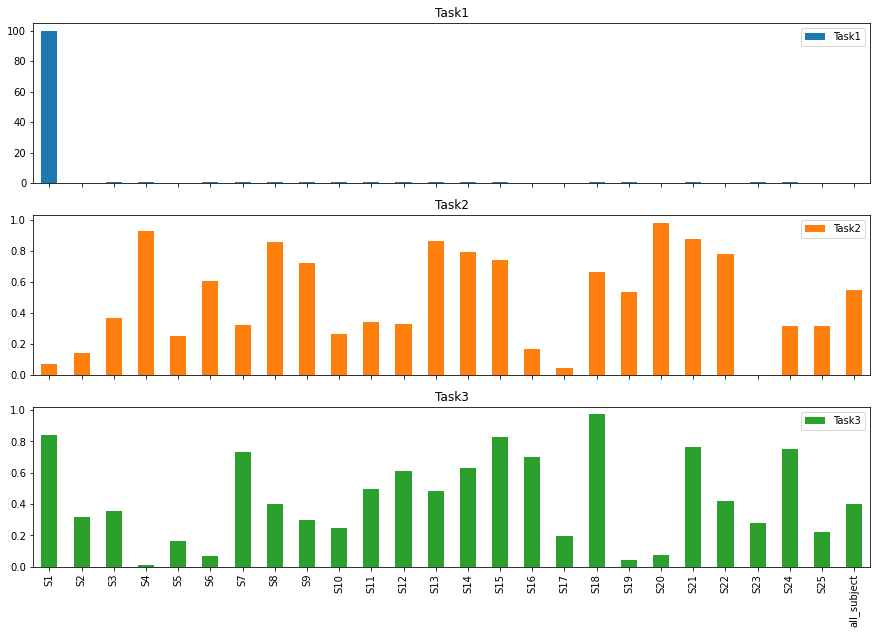

In [68]:
result.plot.bar(subplots = True, figsize = (15, 10))

In [2]:
x_ls = []
y_ls = []
for subject_No in range(1,3):
#     print("Subject No." + str(subject_No) + ":")
    
    X = pd.read_csv('X{}_trial.csv'.format(subject_No))
    Y = pd.read_csv('PhyAAt_Data/phyaat_dataset/Signals/S{0}/S{0}_Textscore.csv'.format(subject_No))
    x_ls.append(X)
    y_ls.append(Y)
    


In [3]:
All_Subject_Y = pd.concat(y_ls, axis = 0, ignore_index = True)
All_Subject_X_trial = pd.concat(x_ls, axis = 0, ignore_index = True)

In [6]:
trial_group = (All_Subject_X_trial['Trial_No'].shift() != All_Subject_X_trial['Trial_No']).cumsum()
All_Subject_X_trial['Trial_No'] = trial_group


All_Subject_Y['trial_No'] = range(1, len(All_Subject_Y)+1)

In [7]:
X = All_Subject_X_trial
Y = pu.preprocess_Y(subject_No)


In [8]:
X

,TimeStamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,Label_N,Label_S,Label_T,Trial_No
0,00:08:59:5138,-3.905409,-4.109658,-4.673459,-5.036478,-0.106369,0.692527,-0.027531,-0.979479,0.136901,3.438352,0.438004,0.650590,-1.259408,0.202234,1000,1,0,1
1,00:08:59:5138,3.749025,-1.810159,-6.282009,-5.173270,1.564089,-1.630181,-3.110391,-2.137532,0.305303,-17.074219,0.626153,0.867540,-1.737493,3.312453,1000,1,0,1
2,00:08:59:5138,2.749431,-9.091007,-3.498157,-6.094919,-0.777821,-0.000082,-2.285026,-0.373486,0.266672,-6.965864,0.136116,0.672692,-0.884477,1.414003,1000,1,0,1
3,00:08:59:5138,1.440520,-8.586300,0.237696,-3.749245,-2.332494,2.979494,-0.699675,0.582150,0.082744,-0.989682,-0.383172,0.524728,0.203029,0.171912,1000,1,0,1
4,00:08:59:5138,-5.754131,-5.173485,0.426342,-4.766405,-0.316168,2.186925,-0.782084,-0.529503,0.168216,25.698606,0.023788,1.203898,0.526216,-0.287937,1000,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553619,00:45:03:9757,-0.167095,1.407880,-0.730052,-1.094839,-0.531589,0.479808,-0.307971,-0.124222,0.028023,-2.820023,0.082924,0.115279,-0.093133,-0.004070,-6,1,2,286
553620,00:45:03:9757,0.194511,-0.681208,-0.438505,-0.288471,0.052431,0.200132,0.890843,0.014726,-0.240199,3.515891,-0.006882,0.097272,-0.260928,-1.493979,-6,1,2,286
553621,00:45:03:9757,1.176347,-1.279497,0.437851,1.004680,0.025343,0.533957,0.923916,-0.176800,-0.242059,1.765801,-0.021834,0.128518,0.512998,-1.508934,-6,1,2,286
553622,00:45:03:9757,0.890944,0.150742,0.790296,0.387354,-0.440600,0.067187,-0.565151,-0.223430,-0.086727,-4.263952,0.038516,-0.035698,0.936986,-0.164471,-6,1,2,286


In [9]:
Y

,TimeStamp,CaseID,SNRdB,Semanticity,TotalW,CorrectWords,Correctness,Semanticity_str,SNRdB_str,Correctness_str,Correctness_label,SNRdB_label,Semanticity_label
0,00:27:07:418,1001,1000,1,3,3,100.000000,1,1000,9,9,3,1
1,00:27:23:805,-3,-3,0,4,4,100.000000,0,-3,9,9,0,0
2,00:27:35:386,-6,-6,0,8,0,0.000000,0,-6,0,0,1,0
3,00:28:01:089,0,0,0,12,4,33.333333,0,0,3,3,2,0
4,00:28:11:050,1,0,1,3,0,0.000000,1,0,0,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,01:02:51:253,1000,1000,0,4,4,100.000000,0,1000,9,9,3,0
139,01:03:08:551,-5,-6,1,9,5,55.555556,1,-6,5,5,1,1
140,01:03:24:978,4,3,1,4,2,50.000000,1,3,5,5,4,1
141,01:03:40:473,-2,-3,1,8,3,37.500000,1,-3,3,3,0,1


In [30]:
all_y.Correctness // 10

0       10.0
1        4.0
2       10.0
3        0.0
4        5.0
        ... 
3592     0.0
3593     2.0
3594     2.0
3595     7.0
3596     2.0
Name: Correctness, Length: 3597, dtype: float64

In [35]:
def new_c_level(row):
    level = row.Correctness // 10
    if level == 10:
        return str(int(level - 1))
    else:
        return str(int(level))

In [36]:
all_y = all_y.assign(Correctness_level = all_y.apply(new_c_level, axis=1))
all_y

,TimeStamp,CaseID,SNRdB,Semanticity,TotalW,CorrectWords,Correctness,Correctness_level
0,00:09:26:736,1001,1000,1,9,9.0,100.000000,9
1,00:09:58:336,4,3,1,9,4.0,44.444444,4
2,00:10:21:664,1000,1000,0,8,8.0,100.000000,9
3,00:10:32:806,-5,-6,1,12,0.0,0.000000,0
4,00:10:43:826,-6,-6,0,4,2.0,50.000000,5
...,...,...,...,...,...,...,...,...
3592,00:44:08:984,-6,-6,0,12,0.0,0.000000,0
3593,00:44:23:771,0,0,0,5,1.0,20.000000,2
3594,00:44:39:037,-6,-6,0,4,1.0,25.000000,2
3595,00:45:03:076,6,6,0,9,7.0,77.777778,7


In [43]:
all_y['trial_No'] = range(1, len(all_y)+1)

In [44]:
all_y

,TimeStamp,CaseID,SNRdB,Semanticity,TotalW,CorrectWords,Correctness,Correctness_level,trial_No
0,00:09:26:736,1001,1000,1,9,9.0,100.000000,9,1
1,00:09:58:336,4,3,1,9,4.0,44.444444,4,2
2,00:10:21:664,1000,1000,0,8,8.0,100.000000,9,3
3,00:10:32:806,-5,-6,1,12,0.0,0.000000,0,4
4,00:10:43:826,-6,-6,0,4,2.0,50.000000,5,5
...,...,...,...,...,...,...,...,...,...
3592,00:44:08:984,-6,-6,0,12,0.0,0.000000,0,3593
3593,00:44:23:771,0,0,0,5,1.0,20.000000,2,3594
3594,00:44:39:037,-6,-6,0,4,1.0,25.000000,2,3595
3595,00:45:03:076,6,6,0,9,7.0,77.777778,7,3596
